In [1]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM

## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 3)


,PMID,ab,ti
0,9793700,"This randomized, double-blind, placebo-control...",Effect of subcutaneous naratriptan on forearm ...
1,9793701,A multicenter test was conducted to investigat...,Effect of operationalized computer diagnosis o...
2,9793702,Subcutaneous injection of sumatriptan is an ef...,Sumatriptan nasal spray (20 mg/dose) in the ac...
3,9793771,The efficacy and adverse effects of 0.25% apra...,The effect of 0.25% apraclonidine in preventin...
4,9793807,To determine if an intravenous (i.v.) fluid bo...,An intravenous fluid bolus is not necessary be...


## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [3]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    names=["review","EID","PMID","relevant","fulltext_relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



,review,PMID,relevant
0,ACEInhibitors,10024335,0
1,ACEInhibitors,10027665,0
2,ACEInhibitors,10027935,0
3,ACEInhibitors,10028936,0
4,ACEInhibitors,10029645,1


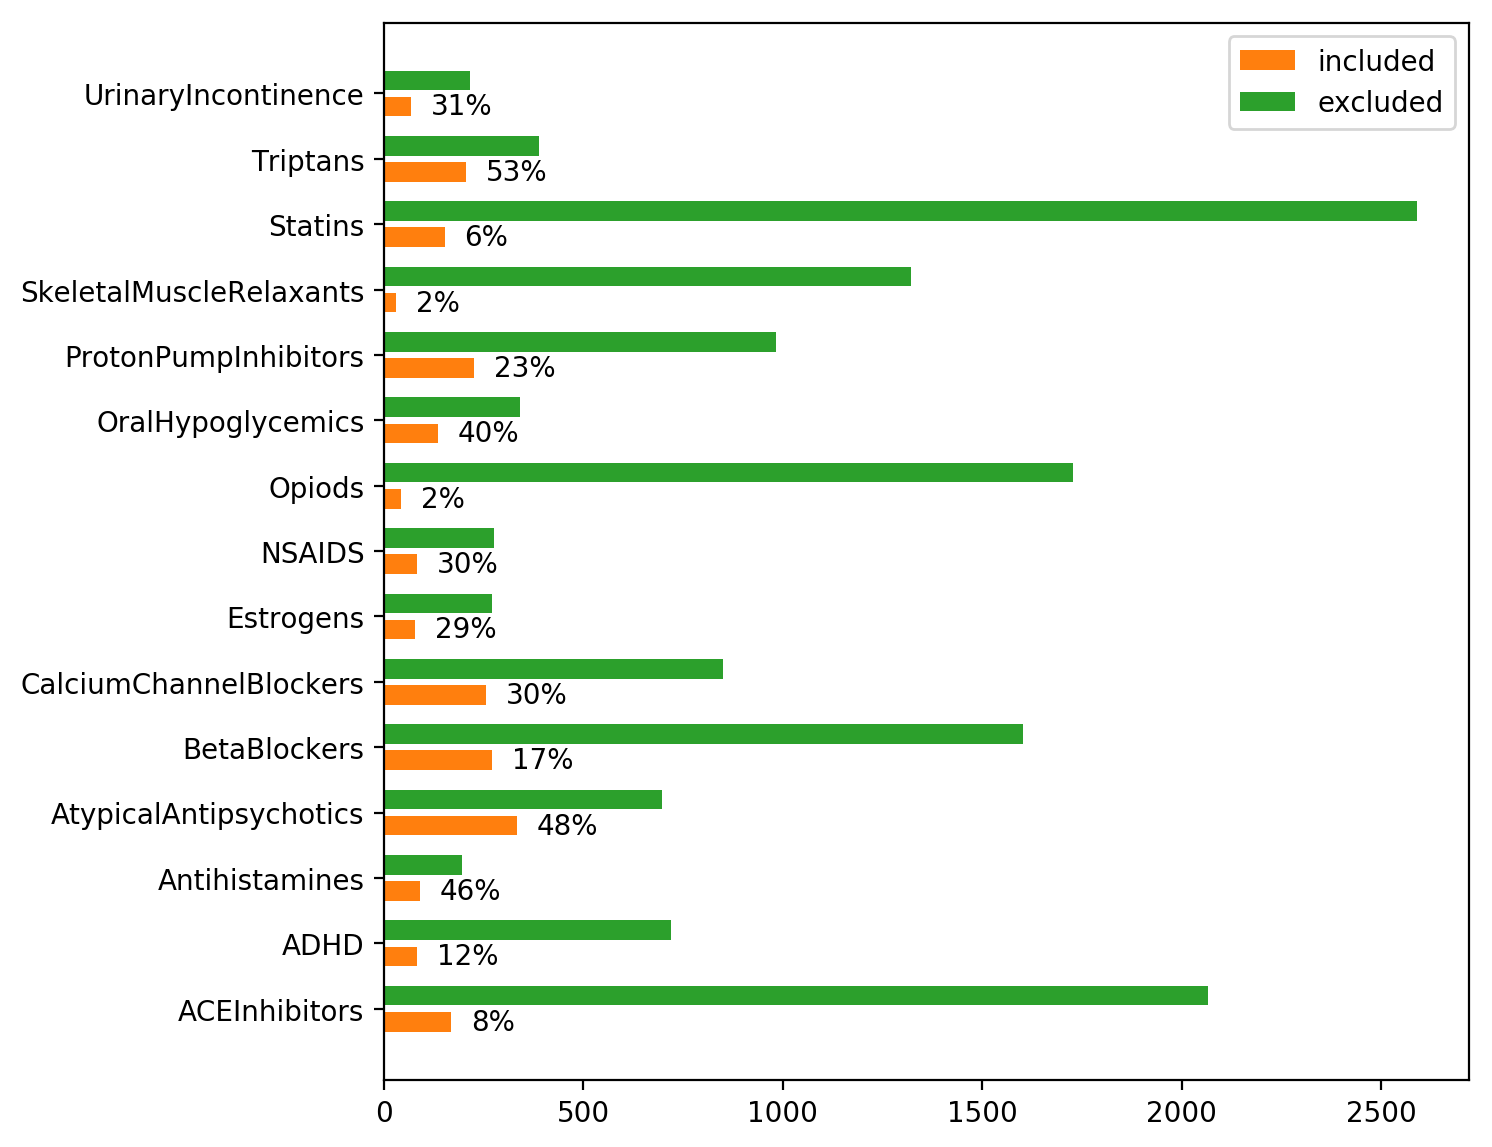

In [4]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/excluded:.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [166]:
importlib.reload(rr)

recalculate = True
if recalculate:
    models = [
        SVC(kernel='linear',C=2,probability=True)
    ]
    iterations = 1

    results = []
    rs_results = []
    paths = []
    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        if name not in ["ACEInhibitors","BetaBlockers"]:
            continue
        ss = rr.ScreenScenario(
            df, models, 500, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, False))
            rs_results.append(ss.screen(i, True))
            paths.append({
                "dataset": name,
                "work_path": ss.work_track,
                "recall_path": ss.recall_track,
                "estimated_recall_path": ss.estimated_recall_path
            })

    results_2 = pd.DataFrame.from_dict(results)
    rs_results_2 = pd.DataFrame.from_dict(rs_results)
    print(rs_results_df.shape)

    
else:
    results_df = pd.read_csv('../results/results.csv')
    rs_results_df = pd.read_csv('../results/rs_results.csv')
    
rs_results_df.head()    
path_df = pd.DataFrame.from_dict(paths)

Dataset: BetaBlockers, iteration 0.  1750 out of 1873 documents seen
(2, 9)


In [ ]:
rs_results_2.head()

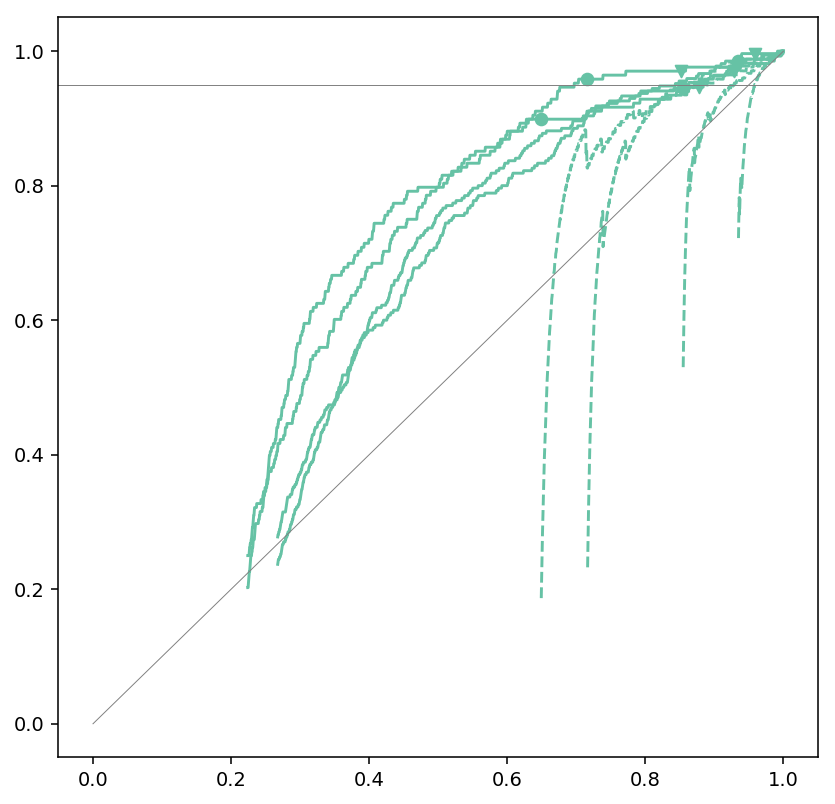

In [154]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']
#for i, p in enumerate(paths):
for i, p in path_df.iterrows():
    ax.plot(p['work_path'],p['recall_path'], c=colors[0])    
    ax.plot(p['work_path'][-len(p['estimated_recall_path']):],p['estimated_recall_path'], c=colors[0], linestyle="--")    
    ax.scatter(
        rs_results_2.loc[i,'random_start_work'],
        rs_results_2.loc[i,'random_start_recall'],
        c=colors[0],
        marker = "o"
    )
    ax.scatter(
        1-rs_results_2.loc[i, 'wss95_rs'],
        rs_results_2.loc[i, 'recall_rs'],
        c=colors[0],
        marker="v"
    )
    
ax.axhline(0.95, color="grey",lw=0.5)
ax.plot([0,1],[0,1], color="grey", lw=0.5)

plt.show()

In [105]:
import random
self.reset()
self = ss
self.df['seen'] = 0

rs = True

s = self.s
self.iteration = i
self.reset()

## Do the random sample
sids = random.sample(list(self.df.index), s)
self.df.loc[sids,'seen'] = 1

for clf in self.models:
    learning = True
    while learning:
        print(f"Dataset: {self.dataset}, iteration {self.iteration}.  {self.seen_docs} out of {self.N} documents seen")
        index = self.df.query('seen==1').index
        unseen_index = self.df.query('seen==0').index
        if len(unseen_index) == 0:
            learning=False
            break
        x = self.X[index]
        y = self.df.query('seen==1')['relevant']
        if len(set(y))<2:
            y_pred = [random.random() for x in unseen_index]
        else:
            clf.fit(x,y)
            y_pred = clf.predict_proba(self.X[unseen_index])[:,1]
            if rs:
                if max(y_pred) < 0.1:
                    break
                    #r = self.sample_threshold()
        next_index = unseen_index[(-y_pred).argsort()[:self.iteration_size]]
        for i in next_index:
            self.df.loc[i,'seen'] = 1
            self.ratings.append(self.df.loc[i,'relevant'])
            self.seen_docs = self.df.query('seen==1').shape[0]
            self.r_seen = self.df.query('seen==1 & relevant==1').shape[0]
            self.recall_track.append(self.r_seen / self.r_docs)
            self.work_track.append(self.seen_docs / self.N)
            last_ratings = self.ratings[-self.irrelevant_heuristic:]
            self.recall = self.r_seen / self.r_docs

Dataset: ACEInhibitors, iteration 1.  0 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  850 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  900 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  950 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1000 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1050 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1100 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1150 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1200 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1250 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1300 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1350 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1400 out of 2235 documents seen
Dataset: ACEInhibitors, iteration 1.  1450 out of 2235 documents seen


In [108]:
self.recall

0.8928571428571429

(array([157., 181., 163., 127.,  94.,  38.,  16.,   7.,   1.,   1.]),
 array([0.0010096 , 0.00754034, 0.01407108, 0.02060181, 0.02713255,
        0.03366328, 0.04019402, 0.04672476, 0.05325549, 0.05978623,
        0.06631696]),
 <a list of 10 Patch objects>)

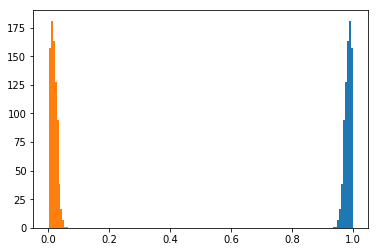

In [107]:
plt.hist(clf.predict_proba(self.X[unseen_index])[:,0])

plt.hist(clf.predict_proba(self.X[unseen_index])[:,1])

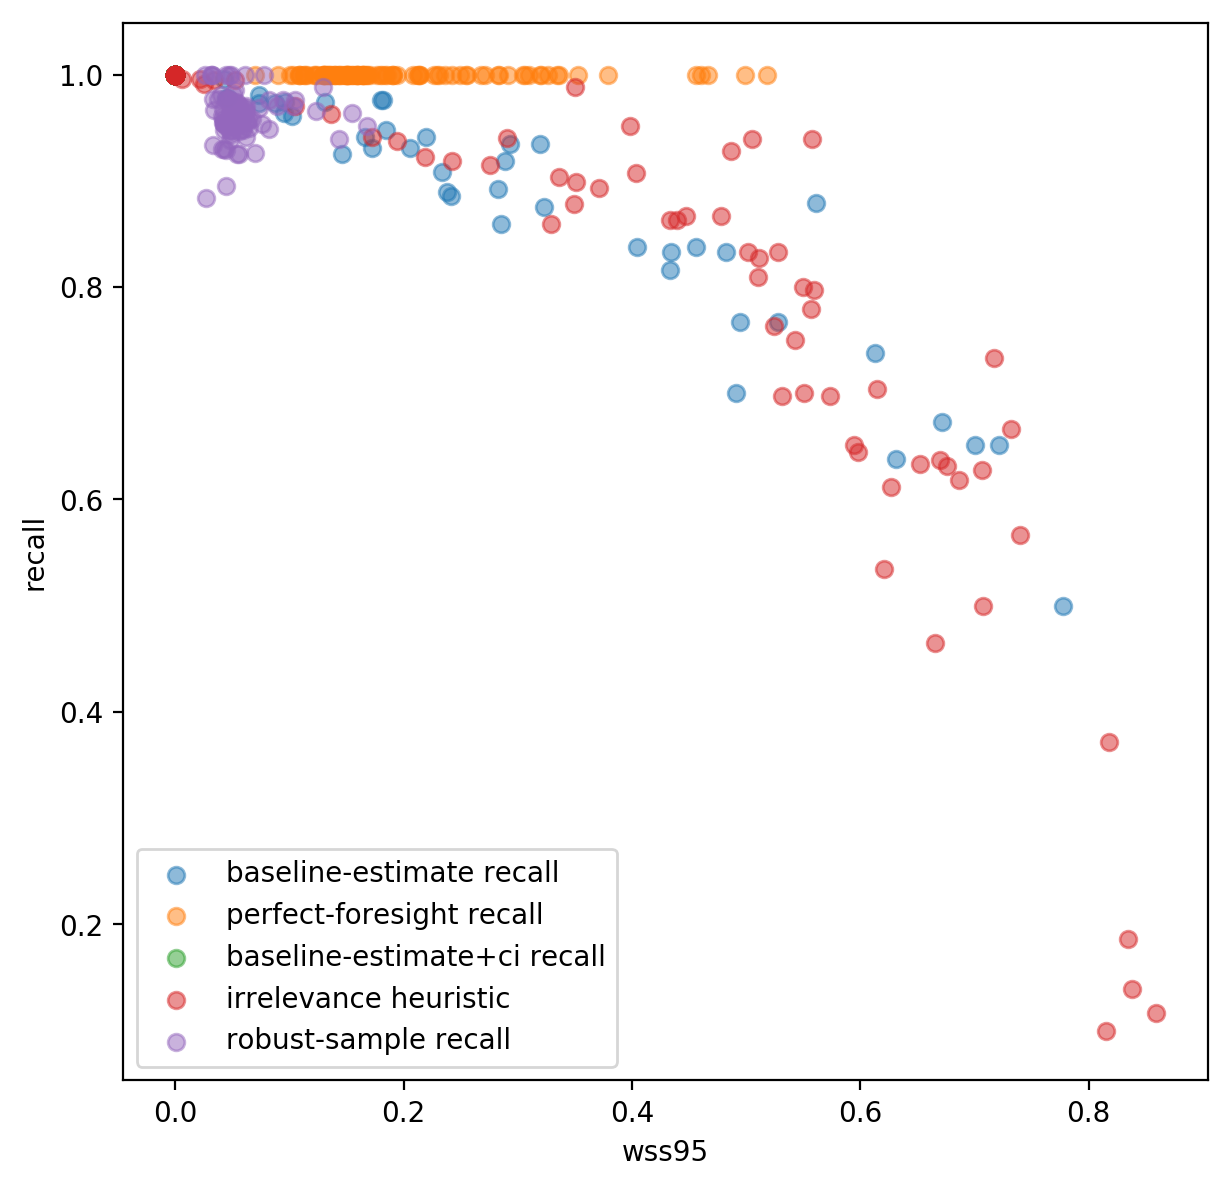

In [8]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.scatter(
    results_df['wss95_bir'], results_df['recall_bir'], 
    alpha=0.5, 
    label="baseline-estimate recall"
)
ax.scatter(
    results_df['wss95_pf'], 
    results_df['recall_pf'], 
    alpha=0.5,
    label="perfect-foresight recall"
)

ax.scatter(
    results_df['wss95_bir_ci'], 
    results_df['recall_bir_ci'], 
    alpha=0.5,
    label="baseline-estimate+ci recall"
)

ax.scatter(
    results_df['wss95_ih'], 
    results_df['recall_ih'], 
    alpha=0.5,
    label="irrelevance heuristic"
)

ax.scatter(
    rs_results_df['wss95_rs'], rs_results_df['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')
plt.show()

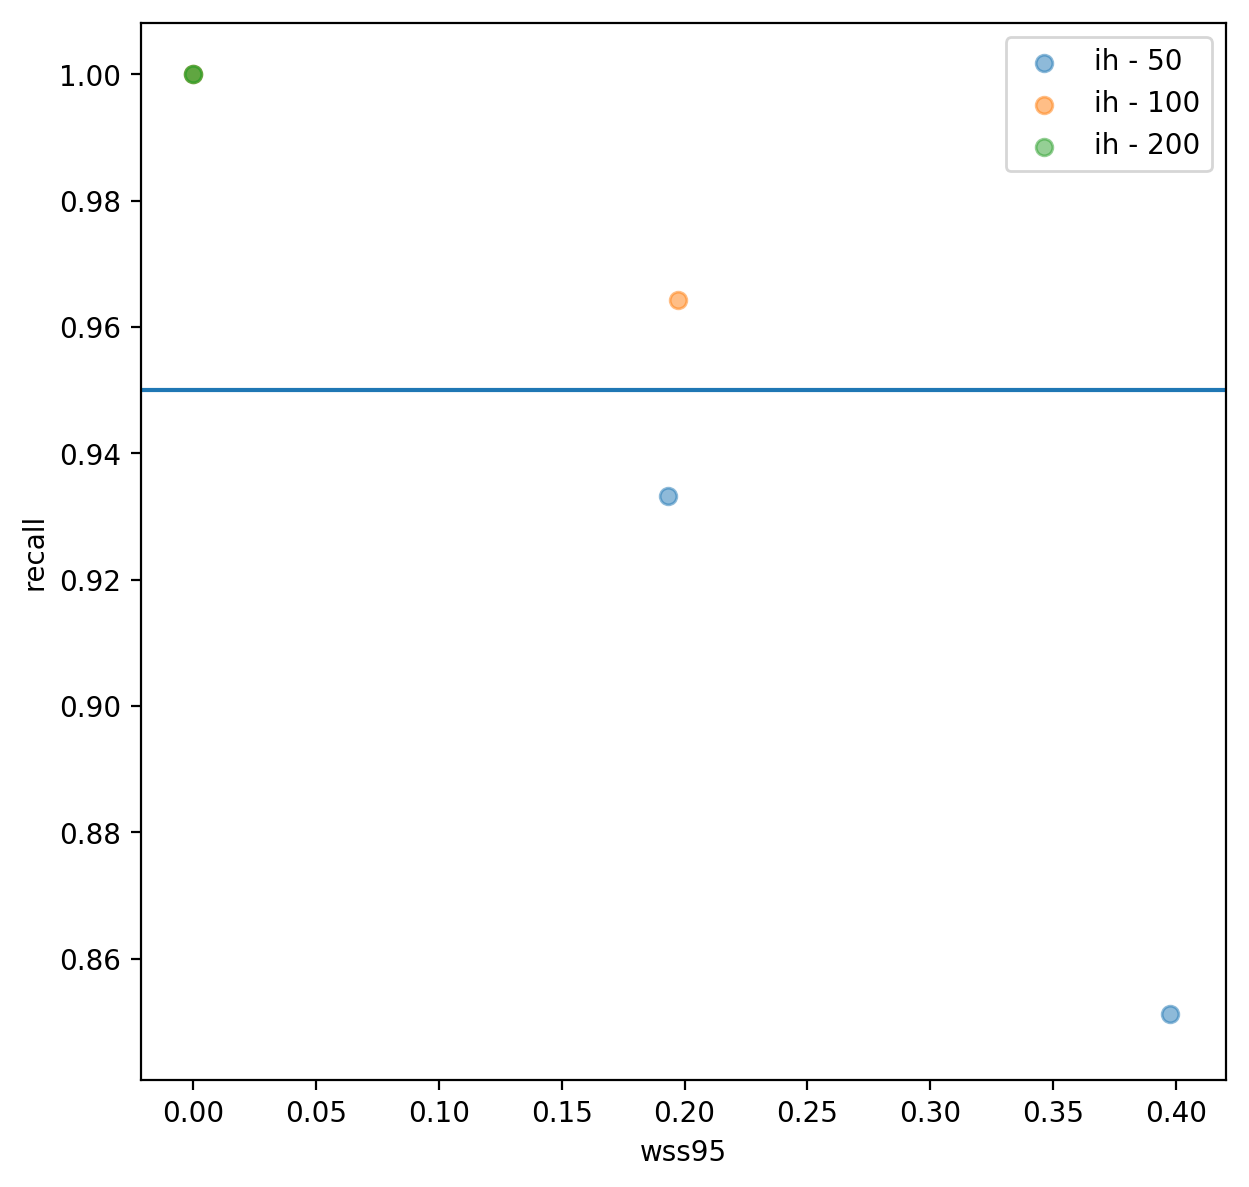

In [164]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_2[f'wss95_ih_{ih}'], results_2[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

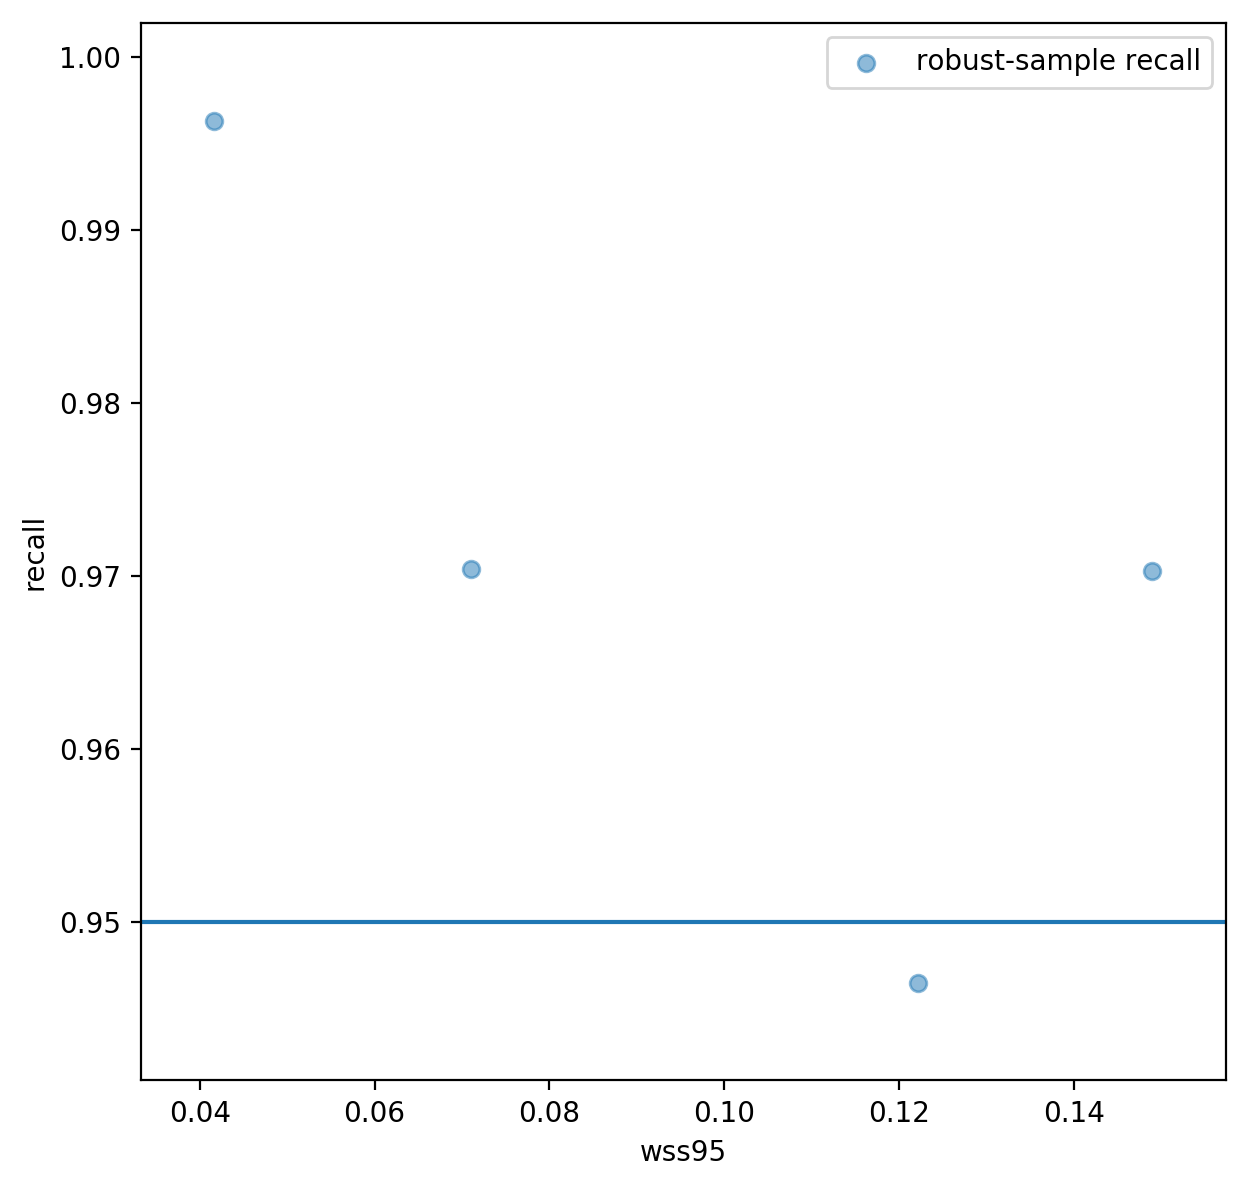

In [156]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.scatter(
    rs_results_2['wss95_rs'], rs_results_2['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.show()

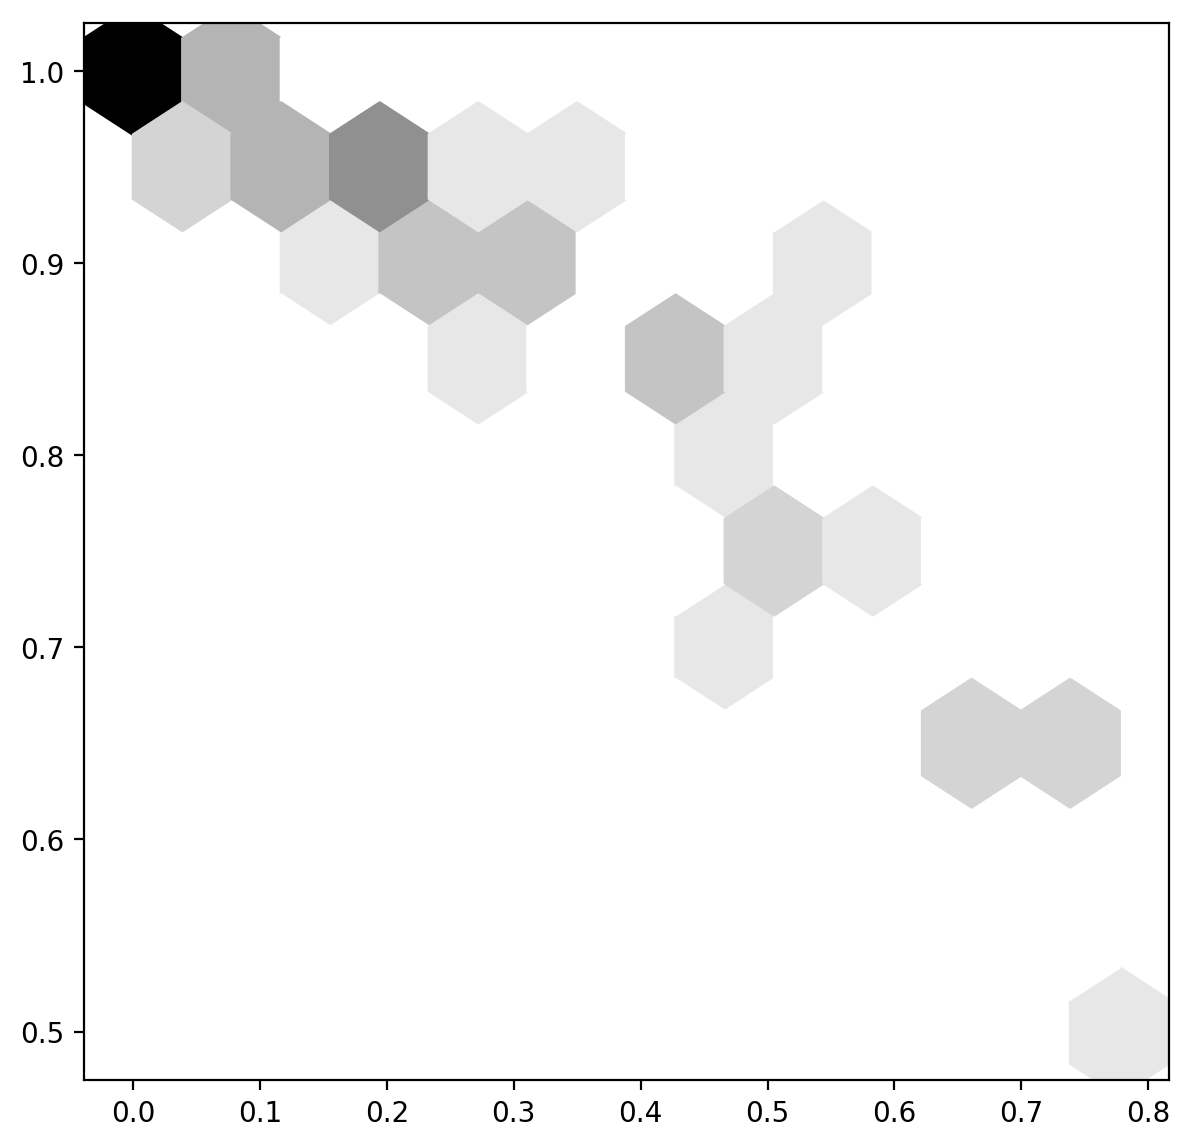

In [15]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_bir'], 
    results_df['recall_bir'], 
    gridsize=10, 
    mincnt=0,
    bins="log",
    cmap = "Greys"
)
plt.show()

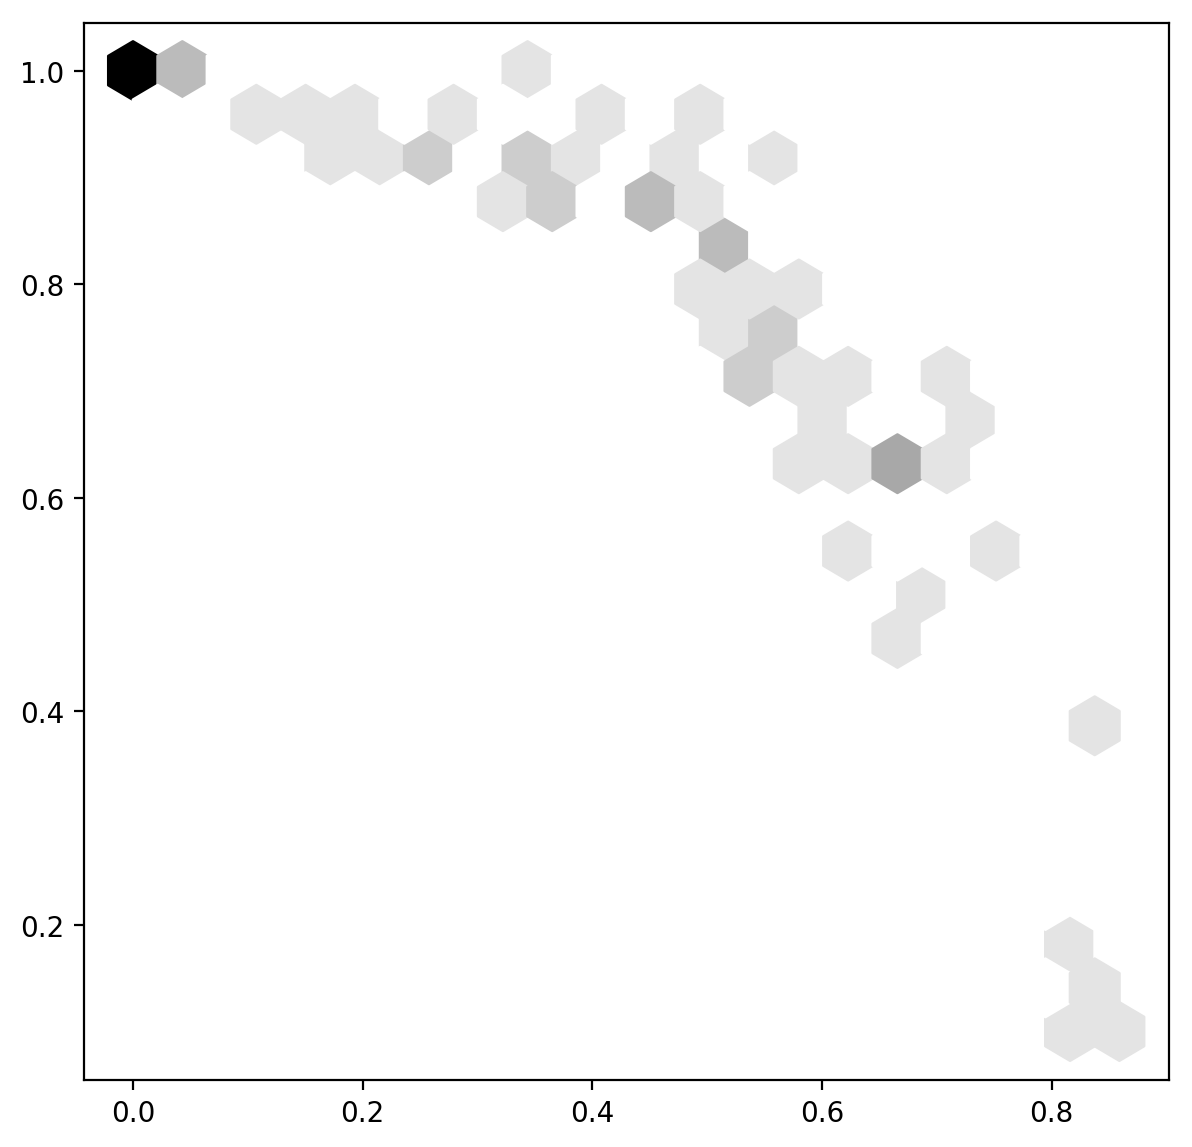

In [14]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_ih'], 
    results_df['recall_ih'], 
    gridsize=20, 
    mincnt=0,
    cmap="Greys",
    bins="log"
)
plt.show()

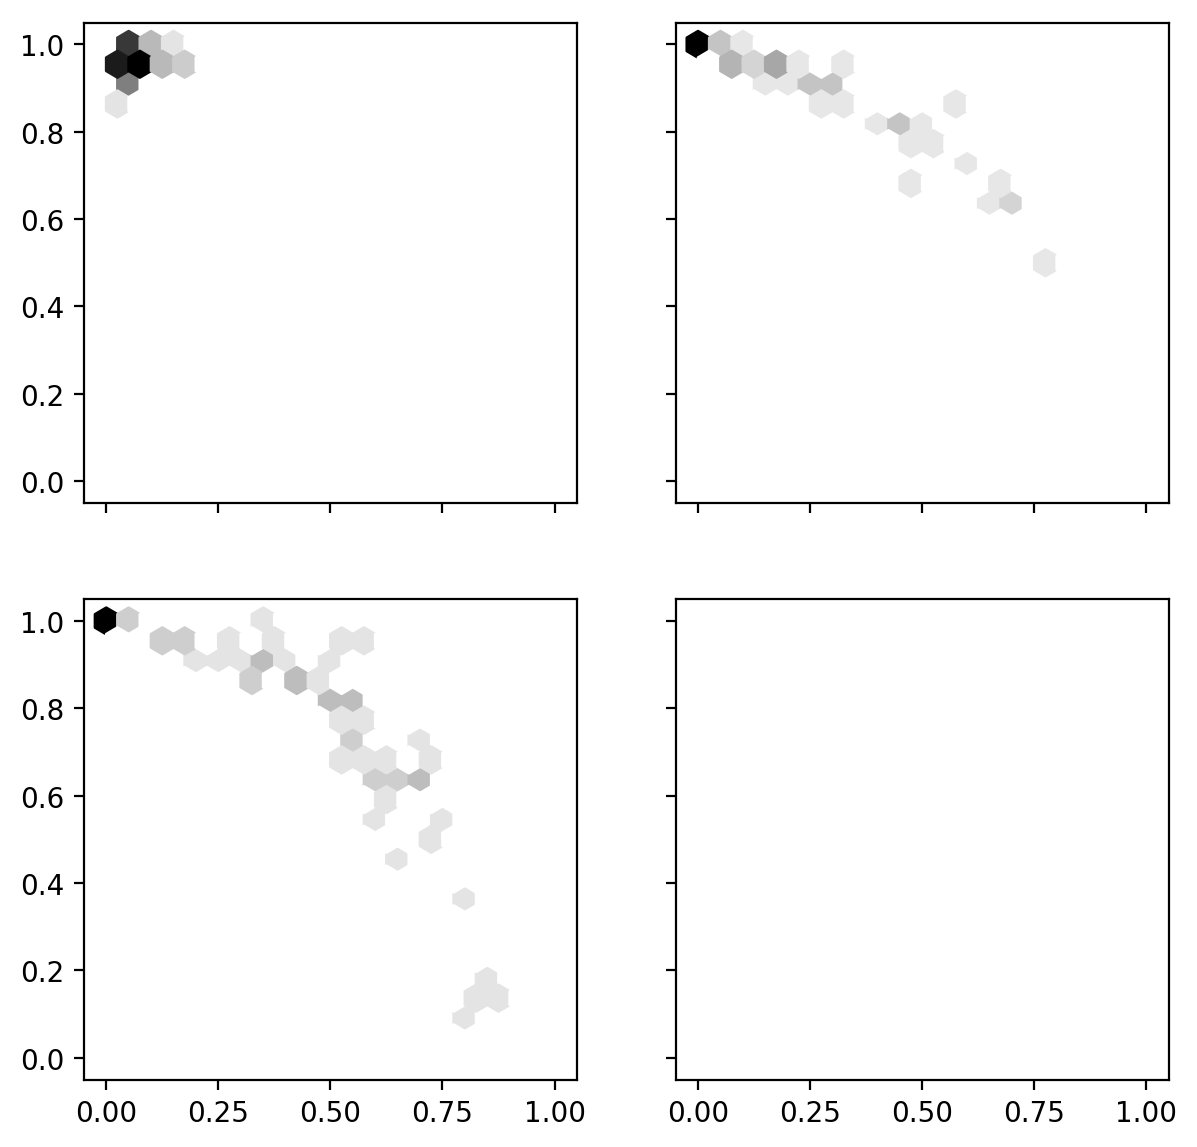

In [47]:
fig, axs = plt.subplots(2,2,figsize=(7,7),dpi=200,sharey=True, sharex=True)

for i, ss in enumerate(['_rs','_bir','_ih']):
    ax = axs[i//2][i%2]
    ax.hexbin(
        results_all[f'wss95{ss}'].dropna(), 
        results_all[f'recall{ss}'].dropna(), 
        gridsize=20, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
plt.show()    

In [49]:
rs_results_df.head()

,dataset,iteration,random_start_recall,random_start_work,recall_pf,recall_rs,s,wss95_pf,wss95_rs
0,ACEInhibitors,0,0.071429,0.089485,0.952381,0.958333,200,0.044743,0.042058
1,ACEInhibitors,1,0.363095,0.156600,0.952381,0.958333,200,0.059060,0.055034
2,ACEInhibitors,2,0.196429,0.111857,0.952381,0.946429,200,0.043848,0.047875
3,ACEInhibitors,3,0.267857,0.134228,0.952381,0.964286,200,0.056376,0.049664
4,ACEInhibitors,4,0.095238,0.089485,0.952381,0.928571,200,0.030872,0.044743


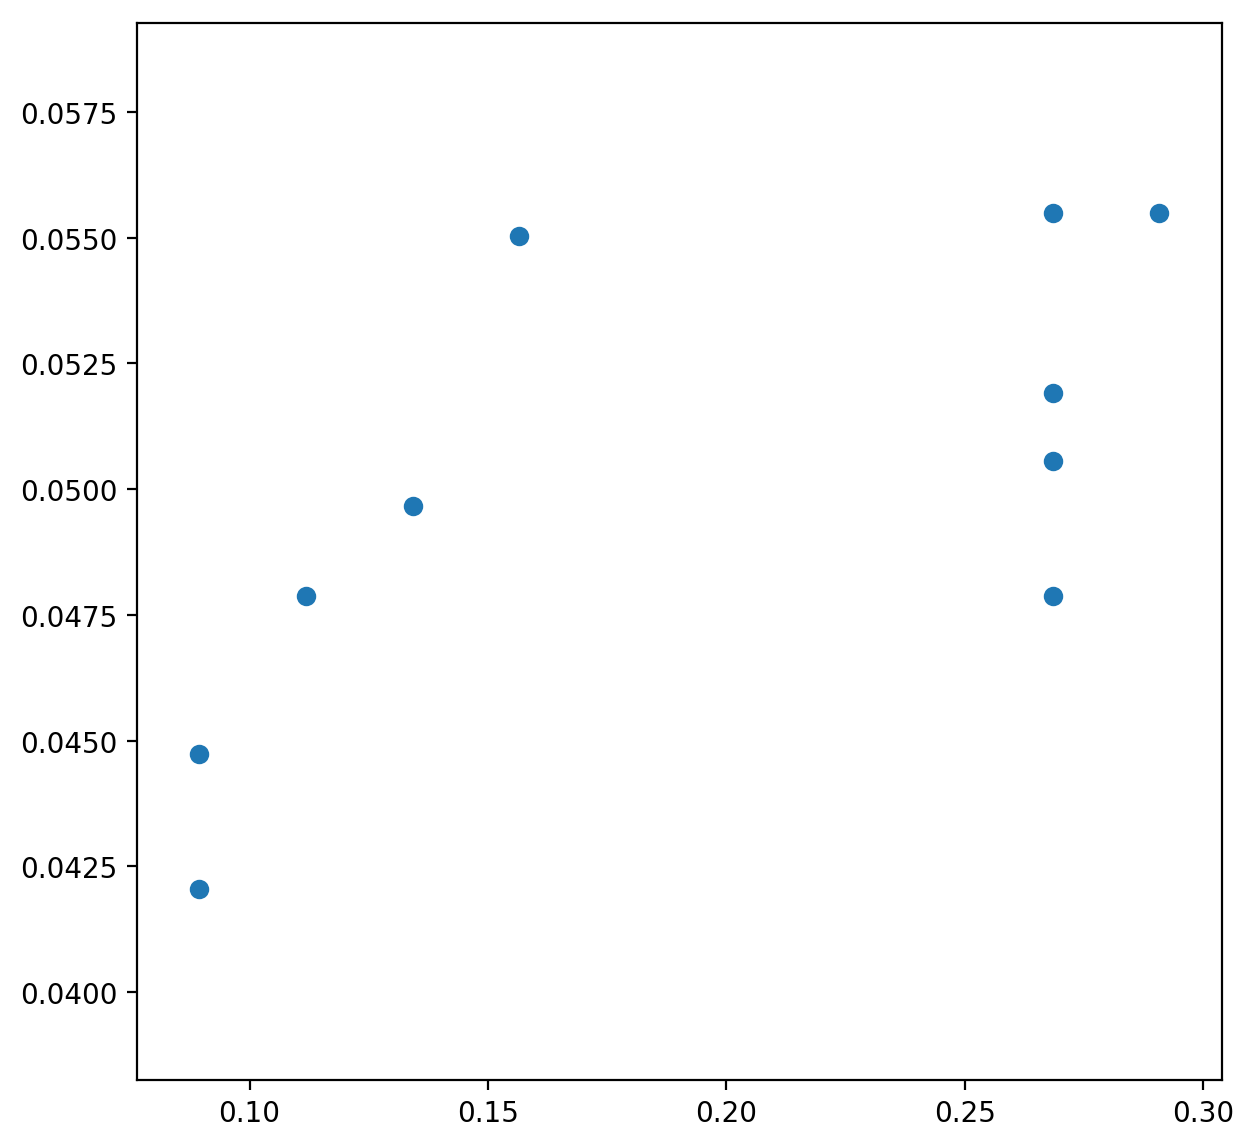

In [53]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

df = rs_results_df[rs_results_df['dataset']=='ACEInhibitors']
ax.scatter(
    df['random_start_work'], 
    df['wss95_rs'], 
)
plt.show()